c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
c:\Users\guyda\anaconda\envs\ce-rnn\lib\site-packages\gym\utils\passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


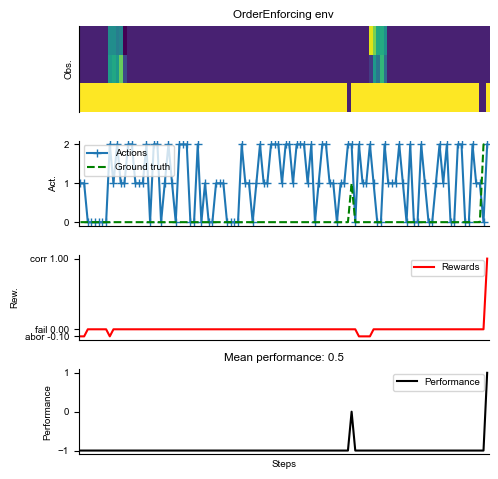

In [172]:
import neurogym as ngym

import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
dt=20
hidden_size=64
batch_size=16
seq_len=1

kwargs={'dt': dt, 'timing': timing}

dataset = ngym.Dataset(
    task, kwargs, batch_size=batch_size,
    seq_len=seq_len)
env = dataset.env
act_size = env.action_space.n


# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
alpha = 0.9
beta = 0.7

batch_size = 16
num_steps = 100 


In [173]:
import torch
import torch.nn as nn
import snntorch as snn
import numpy as np
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
                                                                        
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
   
net = Net()
   
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data.view(batch_size, -1))
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer():
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(inputs, labels, train=True)
    print_batch_accuracy(test_inputs, test_labels, train=False)
    print("\n")


In [174]:
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
# dtype = torch.float


# loss_values = []  # List to store loss values
# running_loss = 0.0
# print_step = 100
# for i in range(2000):
#   inputs, labels = dataset()

#   inputs = torch.from_numpy(inputs).type(torch.float)
#   labels = torch.from_numpy(labels.flatten()).type(torch.long)

#   spk_rec, mem_rec = net(inputs.reshape(batch_size, -1))
#   loss_val = torch.zeros((1), dtype=dtype)
#   for step in range(num_steps):
#     loss_val += criterion(mem_rec[step], labels)




In [175]:
num_epochs = 1
loss_hist = []
test_loss_hist = []
counter = 0
print_step=10
loss_values=[]
running_loss = 0.0

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9,0.9))
dtype = torch.float



# Minibatch training loop
for i in range(400):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # forward pass
    net.train()
    spk_rec, mem_rec = net(inputs.view(batch_size, -1))

    # initialize the loss & sum over time
    loss_val = torch.zeros((1), dtype=dtype)
    for step in range(num_steps):
        loss_val += criterion(mem_rec[step], labels)

    # Gradient calculation + weight update
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    # Store loss history for future plotting
    loss_hist.append(loss_val.item())
    # print(f"Training loss: {loss_val.item():.3f}")
    # print_batch_accuracy(inputs, labels, train=True)


    running_loss += loss_val.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

        

        

        

        

Step 10, Loss 121.7092
Step 20, Loss 85.7989
Step 30, Loss 55.7878
Step 40, Loss 44.8833
Step 50, Loss 52.0957
Step 60, Loss 54.5084
Step 70, Loss 55.9727
Step 80, Loss 55.1256
Step 90, Loss 64.2131
Step 100, Loss 70.4424
Step 110, Loss 62.3846
Step 120, Loss 50.2131
Step 130, Loss 51.4811
Step 140, Loss 40.0550
Step 150, Loss 43.9503
Step 160, Loss 34.1335
Step 170, Loss 28.7927
Step 180, Loss 32.3901
Step 190, Loss 33.4697
Step 200, Loss 29.6134
Step 210, Loss 21.2412
Step 220, Loss 18.0892
Step 230, Loss 24.4636
Step 240, Loss 39.8033
Step 250, Loss 38.2600
Step 260, Loss 37.4258
Step 270, Loss 45.6796
Step 280, Loss 47.8697
Step 290, Loss 49.6939
Step 300, Loss 50.8857
Step 310, Loss 32.9327
Step 320, Loss 26.0778
Step 330, Loss 19.5681
Step 340, Loss 13.4055
Step 350, Loss 10.7485
Step 360, Loss 18.9822
Step 370, Loss 24.7446
Step 380, Loss 27.0449
Step 390, Loss 31.7232
Step 400, Loss 38.5802


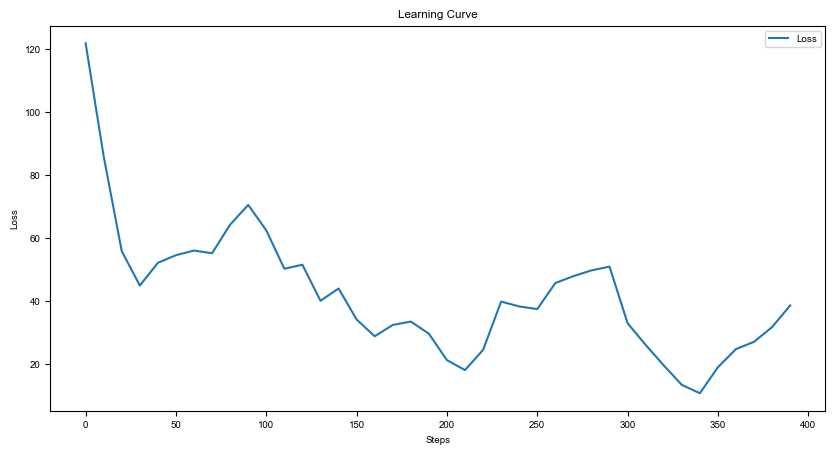

In [176]:
import matplotlib.pyplot as plt


steps = np.arange(0, 400, print_step)

plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(steps,loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [177]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, :, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['decision']]
    #stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))



Average performance 0.0


In [178]:
# Analyze hidden layer activity
hidden_activity = np.array([activity_dict[i] for i in range(num_trial)])

# Calculate mean and standard deviation of hidden layer activity
mean_activity = np.mean(hidden_activity, axis=0)
std_activity = np.std(hidden_activity, axis=0)

print("Mean hidden layer activity:\n", mean_activity)
print("Standard deviation of hidden layer activity:\n", std_activity)

# Plot mean and standard deviation of hidden layer activity
plt.figure(figsize=(12, 6))
for neuron in range(hidden_size):
    plt.plot(mean_activity[:,, neuron], label=f'Neuron {neuron}')
plt.fill_between(range(mean_activity.shape[0]), 
                 mean_activity[:, neuron] - std_activity[:, neuron], 
                 mean_activity[:, neuron] + std_activity[:, neuron], alpha=0.2)
plt.title("Mean and Standard Deviation of Hidden Layer Activity")
plt.xlabel("Time Step")
plt.ylabel("Activity")
plt.legend()
plt.show()

SyntaxError: invalid syntax (2969003875.py, line 14)

(100, 130, 1, 3)
(100, 130, 3)


C:\Users\guyda\AppData\Local\Temp\ipykernel_24968\1712211004.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


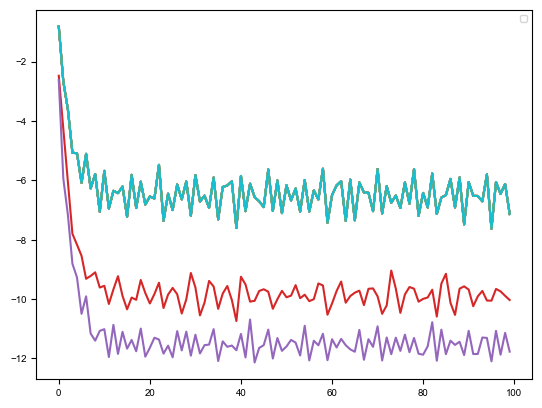

In [ ]:
# @title Plot neural activity from sample trials
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)


import matplotlib.pyplot as plt

trial = 400
print(activity_dict[trial].shape)
print(activity_dict[trial].squeeze().shape)
for i in range(10):
    plt.plot(activity_dict[trial].squeeze()[:,10*i,2])
plt.legend()
